In [1]:
%matplotlib inline
import os
import numpy as np
import numpy.random as ra
import matplotlib.pyplot as plt

import skimage 
from skimage import io
from skimage.measure import regionprops
from skimage.morphology import square
from skimage.segmentation import clear_border
from skimage.feature import peak_local_max

import scipy as sp
from scipy import ndimage
import glob

import matplotlib.pyplot as plt

In [2]:
dpath=os.path.abspath("")
dpath

'/home/taku/pyproject/decode_copy/ShiroguchiT'

In [3]:
savepath_ProB = dpath+"/data/prob_bi/"
savepath_LMPP = dpath+"/data/lmpp_bi/"

In [4]:
folder = "/data"
imformat = ".tif"

In [5]:
ProB=glob.glob(dpath+folder+"/ProB/*"+imformat)
LMPP=glob.glob(dpath+folder+"/LMPP/*"+imformat)
mix=glob.glob(dpath+folder+"/mix/*"+imformat)
ProB.sort()
LMPP.sort()

In [6]:
ProB

['/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/0-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/0-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/0-2.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/0-3.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/1-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/1-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/1-2.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/1-3.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/10-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/10-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/10-2.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/10-3.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/11-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB/11-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/ProB

In [7]:
LMPP

['/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/0-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/0-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/0-2.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/0-3.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/1-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/1-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/1-2.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/1-3.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/10-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/10-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/10-2.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/10-3.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/11-0.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP/11-1.tif',
 '/home/taku/pyproject/decode_copy/ShiroguchiT/data/LMPP

In [8]:
dict = {}
dict["prob"]=ProB
dict["lmpp"] = LMPP
print dict.keys()

['prob', 'lmpp']


In [9]:
def padwithtens(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

In [10]:
def make_mask(image):
    thresh = skimage.filters.threshold_otsu(image)
    mask = skimage.morphology.closing(image > thresh/2, square(5))
    mask = skimage.morphology.dilation(skimage.morphology.erosion(mask, square(6)), square(7))
    clear_border(mask)
    #mask=np.pad(mask, 20, padwithtens)
    return mask

In [11]:
def make_label(mask):
    distance = skimage.filters.gaussian_filter(ndimage.distance_transform_edt(mask),3)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
    markers = skimage.measure.label(local_maxi)
    labels_ws = skimage.morphology.watershed(-distance, markers, mask=mask)
    return labels_ws

In [12]:
def area_hist(dic, cutoff=1800):
    j =0
    area = np.array([])
    for impath in dic:
        image=io.imread(impath)
        mask = make_mask(image[0])
        labels = make_label(mask)
        for i in xrange(len(regionprops(labels))):
            print j
            # skip small images
            if regionprops(labels)[i].area < cutoff:
                continue
            j=j+1
            
            # Record area size of each cell
            area = np.append(area, regionprops(labels)[i].area)        
    return area

In [15]:
def crop_and_save(dic, savepath, size=90, cutoff=1800, pad=50):
    j=0
    area = np.array([])
    #image_dic = {}
    for impath in dic:
        image=io.imread(impath)
        mask = make_mask(image[0])
        labels = make_label(mask)
        
        image = np.pad(image, pad, padwithtens)[pad:pad+4]
        mask = np.pad(mask, pad, padwithtens)
        labels = np.pad(labels, pad, padwithtens)
        for i in xrange(len(regionprops(labels))):
            print j
            # skip small images
            if regionprops(labels)[i].area < cutoff:
                continue
            j=j+1
            
            # Record area size of each cell
            area = np.append(area, regionprops(labels)[i].area)
            # aplly mask to image 
            minr, minc, maxr, maxc = (regionprops(labels)[i]).bbox
            arr = (labels == i+1)*image
            arr = arr[:,(maxr+minr-size)*0.5:(maxr+minr+size)*0.5,(maxc+minc-size)*0.5:(maxc+minc+size)*0.5]
            np.save(savepath+str(j)+".npy",  arr)
            #image_dic[ j ]=arr
            
        
    return area

### 切り取りとサイズ計測

In [17]:
lmpp_area = crop_and_save(dict["lmpp"],savepath=savepath_LMPP)
np.save('lmpp_area.npy',  lmpp_area)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
178
179
180
180
180
180
181
182
183
183
184
184
184
184
185
185
186
187
188
188
189
190
191
192
193
193
194
195
196
196
196
196
197
198
198
199
200
201
202
203
204
204
205
206
207
207
208
208
208
208
209
210
210
211
211
212
213
214
215
216
217
217
217
218
219
220
221
222
223
224
225
225
225
225
225
226
226
226
227
228
229
230
231
232
232
233
233
234
235
236
236
236
236
236
237
238
239
240
24

In [18]:
prob_area = crop_and_save(dict["prob"],savepath=savepath_ProB)
np.save('prob_area.npy',  prob_area)

0
0
0
1
2
3
3
4
5
6
7
8
9
10
11
12
13
14
15
16
16
16
17
18
19
20
21
22
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
45
46
47
48
48
48
49
50
51
52
53
54
55
56
57
58
58
59
60
61
62
63
64
64
64
64
65
66
67
68
69
70
71
72
73
74
75
76
77
77
77
78
78
79
80
81
82
83
84
84
85
85
86
86
87
88
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
110
111
111
111
112
113
114
115
116
117
118
119
120
121
122
123
124
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
140
141
142
142
143
143
144
144
145
146
147
148
149
150
151
152
153
154
155
156
156
157
158
159
159
159
159
160
160
161
162
163
164
164
165
166
167
168
169
170
171
172
173
174
175
176
176
177
178
179
180
180
180
180
181
181
181
182
183
184
185
186
187
188
189
190
190
191
192
193
194
194
195
195
195
195
196
197
198
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
217
217
218
218
218
218
219
220
221
222
222
223
224
225
226
227
228
229
230
2

In [19]:
mix_area = crop_and_save(mix, cutoff=1800, savepath=dpath+"/data/mix_bi/")
np.save('mix_area.npy',  mix_area)

0
1
2
2
2
3
4
5
6
6
6
7
8
9
10
11
11
12
13
14
15
16
17
18
19
20
21
22
22
22
22
23
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
48
49
50
51
52
53
54
55
56
57
58
59
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
101
102
103
104
105
106
107
108
109
110
111
111
111
111
111
111
111
112
113
114
115
116
116
117
118
118
119
120
121
122
123
123
123
123
123
123
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
154
155
156
157
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
206
207
208
208
209
210
211
212
213
214
215
216
217
218
218
219
220
221
222
223
224
224
225
225
226
227
228
229
230
231
232
233
234
235
236
236
237
238
239
240
241
242
243
244
245
2

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


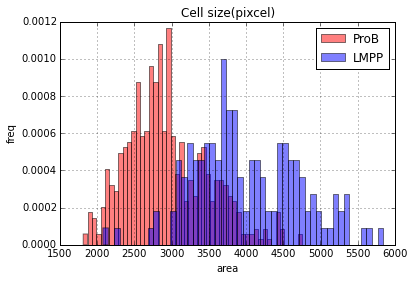

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(hoge, bins=50, normed=True, color='red',alpha=0.5, label="ProB")
ax.hist(fuga, bins=50, normed=True, color='blue',alpha=0.5, label="LMPP")
ax.set_title('Cell size(pixcel)')
ax.set_xlabel('area')
ax.set_ylabel('freq')

ax.grid(True)
ax.legend(loc="upper right")

fig.show()
plt.savefig('cellsize.png')

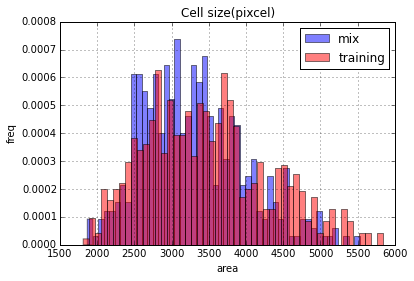

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(mix_area, bins=50, normed=True, color='blue',alpha=0.5, label="mix")
ax.hist(data, bins=50, normed=True, color='red',alpha=0.5, label="training")

ax.set_title('Cell size(pixcel)')
ax.set_xlabel('area')
ax.set_ylabel('freq')

ax.grid(True)
ax.legend(loc="upper right")

fig.show()
plt.savefig('hogehoge.png')

In [27]:
print len(lmpp_area)
print len(prob_area)

print np.mean(lmpp_area)
print np.mean(prob_area)

584
2992
3998.06849315
2923.52673797


### 大きさで識別

In [21]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

In [22]:
perm = np.random.permutation(len(prob_area))
hoge = prob_area[perm[:len(lmpp_area)]]
perm = np.random.permutation(len(lmpp_area))
fuga =  lmpp_area[perm]

In [23]:
data = np.r_[fuga, hoge]
labels = np.r_[
        np.zeros(len(fuga)),
        np.ones(len(hoge)),
    ]

In [24]:
scores = cross_val_score(linear_model.LogisticRegression(), data[:, np.newaxis], labels, cv=4)

In [25]:
print scores[0]
print "p-value", np.mean(scores[2])

0.790239726027
p-value 0.00990099009901


In [26]:
print np.mean(scores[1])

0.484785958904


In [5]:
a = np.array(range(10))

In [10]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
a[]